In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from hmmlearn import hmm
from pomegranate import *

In [2]:
def detect_outliers(x):

    m = np.mean(x)
    std = np.std(x)
    outlier_idx = np.where((m - 3 * std > x) | (m + 3 * std < x))[0]

    return outlier_idx

def table_entry(zero, ir, temp, param):

    """
    Mapping sensor measurements to concentration level of CO2 based on Beer-Lambert Law
    :param zero: zero calibration parameter
    :param ir: amount of IR light received by detector
    :param temp: measured environmental temperature
    :param s: span calibration parameter
    :param t0: full transmittance (scaled and shifted transmittance when the target concentration is zero)
    :param tz: temperature calibration parameter, describes the temperature dependency of zero
    :param tz2: temperature calibration parameter, describes the temperature dependency of zero
    :param ts: temperature calibration parameter, describes the temperature dependency of span
    :param ts2: temperature calibration parameter, describes the temperature dependency of span
    :return: table entry
    """

    '''
    The formula is owned by the company.
    '''

    return table_entry

def zero_cal(cc_mea, ir, temp, param):

    """
    Mapping measured concentration level of CO2 to transmittance to calculate zero coefficient
    :param cc_mea: measured concentration level of CO2
    :param cc: concentration level of CO2 offered in the mapping table
    :param te: table entry (transmittance) in the mapping table
    :return: calculated zero coefficient for each concentration level of CO2
    """

    global te, cc
    
    '''
    The formula is owned by the company.
    '''

    return zero

def viterbi_log(y, pi, A, B):

    """
    Viterbi Algorithm
    :param y: observations (N, )
    :param pi: state probability (S, )
    :param A: transition probability matrix (S, S)
    :param B: observation probability matrix (S, N)
    :return: predicted state sequence (N, )
    """

    S = A.shape[0]    # Number of states
    N = len(y)  # Length of observation sequence
    tiny = np.finfo(0.).tiny
    pi_log = np.log(pi + tiny)
    A_log = np.log(A + tiny)
    B_log = np.log(B + tiny)

    # Initialization
    ### Viterbi probability vector
    D_log = np.zeros((S, N))
    D_log[:, 0] = pi_log + B_log[:, y[0]]
    ### Viterbi backpointer matrix
    E = np.zeros((S, N - 1)).astype(np.int32)

    # Viterbi forward step
    for n in range(1, N):
        for i in range(S):
            temp_sum = A_log[:, i] + D_log[:, n - 1]
            D_log[i, n] = np.max(temp_sum) + B_log[i, y[n]]
            E[i, n - 1] = np.argmax(temp_sum)

    # Backtracking
    S_opt = np.zeros(N).astype(np.int32)
    S_opt[-1] = np.argmax(D_log[:, -1])
    for n in range(N - 2, -1, -1):
        S_opt[n] = E[int(S_opt[n + 1]), n]

    return S_opt

def state_map(pre_states):

    itvl = bins[-1] - bins[-2]      # interval
    pre_zeros = np.zeros(N)
    for i in np.unique(pre_states):
    # for i in range(nos):
        #j = int(np.floor(i / nod))
        j = i % noz
        if j == 0:
            pre_zeros[pre_states == i] = bins[j] - itvl / 2
        elif j == len(bins):
            pre_zeros[pre_states == i] = bins[-1] + itvl / 2
        else:
            pre_zeros[pre_states == i] = (bins[j] + bins[j - 1]) / 2
    return pre_zeros

def plot_figs(y, xticks, fig='CO2'):

    n = len(y[0])
    plt.figure()
    for yy in y:
        plt.plot(np.arange(n), yy)
    if fig == 'CO2_mea':
        plt.xlabel('Date')
        plt.ylabel('Concentration level of CO2 (ppm)')
        plt.legend(labels=['measured'])
        plt.title('Concentration Level of CO2')
    if fig == 'CO2':
        plt.xlabel('Date')
        plt.ylabel('Concentration level of CO2 (ppm)')
        plt.legend(labels=['reference', 'predicted', 'measured', 'baseline'])
        plt.title('Concentration Level of CO2')
    if fig == 'states':
        plt.xlabel('Date')
        plt.ylabel('Hidden state')
        plt.legend(labels=['calculated with reference', 'predicted'])
        plt.title('Hidden States')
    if fig == 'zeros':
        plt.xlabel('Date')
        plt.ylabel('Zero coefficient')
        plt.legend(labels=['calculatd with reference', 'predicted', 'measured', 'baseline'], loc='lower right')
        plt.title('Zero Coefficients')
    plt.xticks(np.arange(0, n, step=int(n / 2 - 1)), xticks[:: int(n / 2 - 1)])
    plt.show()

In [16]:
def load_data(path, label, start, length, step):

    """
    Obtain data for supervised HMM learning.
    :param label: label of sensor, e.g. label=0
    """

    global param, zeros, mea_zeros, data_date, data_temp, data_ir, data_CO2, ref_CO2, N, delta_temp

    '''
    # Swiss data
    info = pd.read_csv('calibrationParametersAndTablesIntegrated.csv', delimiter=';')
    info = info.loc[:, ['Label', 'Tz', 'Tz2', 'Ts', 'Ts2', 'Zero', 'Span']]
    param = info.iloc[1]
    data = pd.read_csv('1029_LP8_1029.csv', delimiter=';')
    data = data.dropna()
    data = data.drop(data.index[detect_outliers(data.lp8_T)])
    data = data.drop(data.index[detect_outliers(data.lp8_ir)])
    data = data.drop(data.index[detect_outliers(data.lp8_CO2)])
    data = data[start: start + step * length: step]
    data_date = np.array(data.date)
    data_temp = np.array(data.lp8_T)
    data_ir = np.array(data.lp8_ir)
    data_CO2 = np.array(data.lp8_CO2)
    ref = pd.read_csv('./DUE.csv/DUE.csv', delimiter=';')
    ref = ref.loc[ref['date'].isin(data_date)]
    ref_CO2 = np.array(ref.CO2_DRY)
    ref_T = np.array(ref['T'])
    '''

    # Obtain sensor parameters
    info = pd.read_csv('SensorsParams.csv', delimiter=';', index_col=0)   # LP8 sensors
    param = info.loc['S' + label, :]
    # Preprocess data

    # Format 1
    data = pd.read_csv(path + '/kth_logger_' + label + '.csv', header=None, delimiter=';')
    data = data.loc[:, [0, 1, 5, 6, 8, 10]]
    data = data.dropna()
    data = data.drop(data.index[detect_outliers(data[5])])
    data = data.drop(data.index[detect_outliers(data[6])])
    data = data.drop(data.index[detect_outliers(data[8])])
    data = data.drop(data.index[detect_outliers(data[10])])
    data = data[start: start + step * length: step]
    data_date = np.array(data[0] + ' ' + data[1])
    data_temp = np.array(data[6])
    data_ir = np.array(data[10]) / 256
    data_CO2 = np.array(data[8])
    ref_CO2 = np.array(data[5])
    ref_T = data_temp


    '''
    # Format 2
    data = pd.read_csv(path + '/kth_logger_' + label + '.csv', header=None)
    data = data.loc[:, [0, 4, 5, 7, 9]]
    data = data.dropna()
    data = data.drop(data.index[detect_outliers(data[4])])
    data = data.drop(data.index[detect_outliers(data[5])])
    data = data.drop(data.index[detect_outliers(data[7])])
    data = data.drop(data.index[detect_outliers(data[9])])
    data = data[start: start + step * length: step]
    data_date = np.array(data[0])
    data_temp = np.array(data[5])
    data_ir = np.array(data[9]) / 256
    data_CO2 = np.array(data[7])
    ref_CO2 = np.array(data[4])
    ref_T = data_temp
    '''

    # Calculate zero coefficients by interpolation with mapping table
    zeros = zero_cal(cc_mea=ref_CO2, ir=data_ir, temp=data_temp, param=param)
    mea_zeros = zero_cal(cc_mea=data_CO2, ir=data_ir, temp=data_temp, param=param)
    # Remove data corresponding to irrational zero coefficients
    m = detect_outliers(zeros)
    zeros = np.delete(zeros, m)
    mea_zeros = np.delete(mea_zeros, m)
    data_date = np.delete(data_date, m)
    data_temp = np.delete(data_temp, m)
    data_ir = np.delete(data_ir, m)
    data_CO2 = np.delete(data_CO2, m)
    ref_CO2 = np.delete(ref_CO2, m)
    ref_T = np.delete(ref_T, m)
    N = len(zeros)
    print('N: ', N)

    delta_temp = np.zeros(N)
    for i in range(1, N):
        delta_temp[i] = ref_T[i] - ref_T[i - 1]

    print('min zero: {}, max zero: {}, mean zero: {:.1f}'.format(round(np.min(zeros)), round(np.max(zeros)), np.mean(zeros)))
    print('min CO2: {}, max CO2: {}, mean CO2: {:.1f}'.format(round(np.min(data_CO2)), round(np.max(data_CO2)), np.mean(data_CO2)))
    print('min dT: {}, max dT: {}, mean dT: {}'.format(np.min(delta_temp), np.max(delta_temp), np.mean(delta_temp)))
    plot_figs(y=[zeros], xticks=data_date, fig='zeros')
    plot_figs(y=[data_CO2], xticks=data_date, fig='CO2_mea')

In [24]:
def supervised_hmm():

    global pre_zeros, base_zeros, pre_CO2, base_CO2
    ### Learn model parameters
    tiny = np.finfo(0.).tiny
    # Calculate initial state probability distribution pi
    pi = np.zeros(nos)
    for i in range(N):
        m = zeros_q[i]
        u = dtemp_q[i]
        #pi[nod * m + u] += 1
        pi[m + noz * u] += 1
    pi /= np.sum(pi) + tiny

    # Calculate transition probability matrix A
    A = np.zeros((nos, nos))
    for i in range(N - 1):
        m = zeros_q[i]
        n = zeros_q[i + 1]
        u = dtemp_q[i]
        v = dtemp_q[i + 1]
        #A[nod * m + u][nod * n + v] += 1
        A[m + noz * u][n + noz * v] += 1
    for i in range(nos):
        A[i] /= np.sum(A[i]) + tiny

    # Calculate observation probability matrix B
    B = np.zeros((nos, noo))
    for i in range(N - 1):
        m = zeros_q[i]
        u = dtemp_q[i]
        j = data_CO2_q[i]
        #B[nod * m + u][j] += 1
        B[m + noz * u][j] += 1
    for i in range(nos):
        B[i] /= np.sum(B[i]) + tiny

    ### Test with collected concentration levels of CO2
    # Predict hidden states given observations
    pre_states = viterbi_log(data_CO2_q, pi, A, B)
    #plot_figs(y=[nod * zeros_q + dtemp_q, pre_states], xticks=data_date, fig='states')
    plot_figs(y=[zeros_q + noz * dtemp_q, pre_states], xticks=data_date, fig='states')
    # Map state index to its true value
    pre_zeros = state_map(pre_states)
    # Introduce baseline of zero coefficients
    base_zeros = np.full(N, np.mean(zeros))
    plot_figs(y=[zeros, pre_zeros, mea_zeros, base_zeros], xticks=data_date, fig='zeros')

    # Predict concentration levels of CO2 with predicted zero coefficients
    pre_trans = table_entry(zero=pre_zeros, ir=data_ir, temp=data_temp, param=param)
    base_trans = table_entry(zero=base_zeros, ir=data_ir, temp=data_temp, param=param)
    # Interpolation
    pre_CO2 = np.interp(pre_trans, te, cc)
    base_CO2 = np.interp(base_trans, te, cc)
    plot_figs(y=[ref_CO2, pre_CO2, data_CO2, base_CO2], xticks=data_date, fig='CO2')

In [18]:
def unsupervised_hmm(iter, tole):

    global pre_zeros, base_zeros, pre_CO2, base_CO2
    ### Initialize model parameters
    # state probability distribution pi
    pi = np.ones(nos)
    pi /= np.sum(pi)
    # transition probability matrix A
    A = np.ones((nos, nos))
    for i in range(nos):
        A[i] /= np.sum(A[i])
    # observation probability matrix B
    B = np.ones((nos, noo))
    for i in range(nos):
        B[i] /= np.sum(B[i])

    ### Train HMM with quantized collected concentration levels of CO2
    h = hmm.CategoricalHMM(n_components=nos, implementation='log', algorithm='viterbi', n_iter=iter, tol=tole)
    h.startprob_ = pi
    h.transmat_ = A
    h.emissionprob_ = B
    h.fit(data_CO2_q.reshape(1, -1))
    # Predict hidden states given observations
    _, pre_states = h.decode(data_CO2_q.reshape(1, -1))
    #plot_figs(y=[nod * zeros_q + dtemp_q, pre_states], xticks=data_date, fig='states')
    plot_figs(y=[zeros_q + noz * dtemp_q, pre_states], xticks=data_date, fig='states')
    # Mapping state index to its true value
    pre_zeros = state_map(pre_states)
    # Introduce baseline of zero coefficients
    base_zeros = np.full(N, np.mean(zeros))
    plot_figs(y=[zeros, pre_zeros, mea_zeros, base_zeros], xticks=data_date, fig='zeros')

    # Predict concentration levels of CO2 with predicted zero coefficients
    pre_trans = table_entry(zero=pre_zeros, ir=data_ir, temp=data_temp, param=param)
    base_trans = table_entry(zero=base_zeros, ir=data_ir, temp=data_temp, param=param)
    # Interpolation
    pre_CO2 = np.interp(pre_trans, te, cc)
    base_CO2 = np.interp(base_trans, te, cc)
    plot_figs(y=[ref_CO2, pre_CO2, data_CO2, base_CO2], xticks=data_date, fig='CO2')

N:  135
min zero: 12485, max zero: 12683, mean zero: 12564.0
min CO2: 296, max CO2: 911, mean CO2: 573.3
min dT: -0.059999000000001246, max dT: 0.09999799999999937, mean dT: 0.0005185185185185206


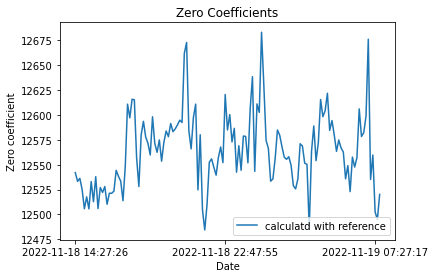

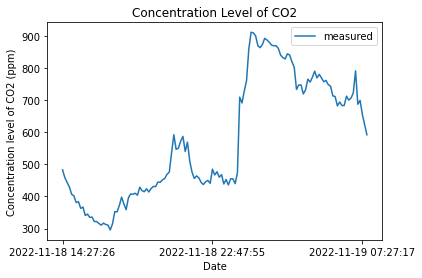

In [21]:
data_path = './19_nov_Same_room'
load_data(data_path, label='01', start=20, length=500, step=7)

In [26]:
# Devise quantization scheme
bins = np.arange(12500, 12640, step=8)
zeros_q = np.digitize(zeros, bins, right=False)
itvl = bins[-1] - bins[-2]      # interval
noz = len(np.unique(zeros_q))   # number of zero states

bins_dtemp = np.arange(-0.01, 0.02, step=0.02)
dtemp_q = np.digitize(delta_temp, bins_dtemp, right=False)
nod = len(np.unique(dtemp_q))   # number of temp states

bins_CO2 = np.arange(330, 890, step=30)
data_CO2_q = np.digitize(data_CO2, bins_CO2, right=False)
noo = len(np.unique(data_CO2_q))   # number of observations

nos = noz * nod
print('zero coefficients:\n\tbins: {} \n\tbincount: {} \n\tnumber of zero states: {} \n\tinterval {} \n'.format(bins, np.bincount(zeros_q), noz, itvl))
print('delta temperatures:\n\tbins: {} \n\tbincount: {} \n\tnumber of temp states: {} \n'.format(bins_dtemp, np.bincount(dtemp_q), nod))
print('CO2 levels:\n\tbins: {} \n\tbincount: {} \n\tnumber of CO2 levels: {}'.format(bins_CO2, np.bincount(data_CO2_q), noo))

zero coefficients:
	bins: [12500 12508 12516 12524 12532 12540 12548 12556 12564 12572 12580 12588
 12596 12604 12612 12620 12628 12636] 
	bincount: [ 3  5  4  7  7 12  7 12 13 10 14 10  7  7  6  3  2  1  5] 
	number of zero states: 19 
	interval 8 

delta temperatures:
	bins: [-0.01  0.01] 
	bincount: [35 66 34] 
	number of temp states: 3 

CO2 levels:
	bins: [330 360 390 420 450 480 510 540 570 600 630 660 690 720 750 780 810 840
 870] 
	bincount: [ 9  7  6 11 16 18  2  2  4  4  1  1  4 10  8  8  4  3  9  8] 
	number of CO2 levels: 20


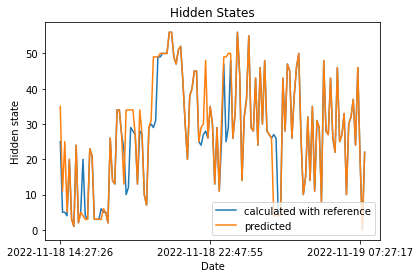

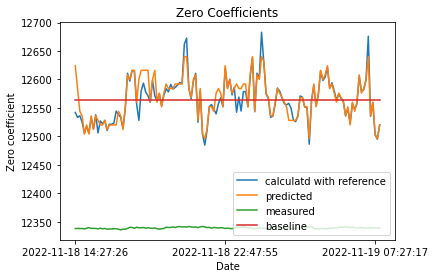

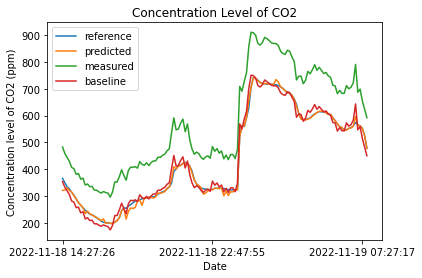

MSE(ref_zeros, mea_zeros): 227.925 
MSE(ref_zeros, pre_zeros): 16.500 
MSE(ref_zeros, base_zeros): 37.252

MSE(ref_CO2, mea_CO2): 137.818 
MSE(ref_CO2, pre_CO2): 9.238 
MSE(ref_CO2, base_CO2): 21.556



In [25]:
supervised_hmm()

# Evaluation
print('MSE(ref_zeros, mea_zeros): {:.3f} \nMSE(ref_zeros, pre_zeros): {:.3f} \nMSE(ref_zeros, base_zeros): {:.3f}\n'.format(np.sqrt(np.linalg.norm(zeros - mea_zeros) ** 2 / N), np.sqrt(np.linalg.norm(zeros - pre_zeros) ** 2 / N), np.sqrt(np.linalg.norm(zeros - base_zeros) ** 2 / N)))
print('MSE(ref_CO2, mea_CO2): {:.3f} \nMSE(ref_CO2, pre_CO2): {:.3f} \nMSE(ref_CO2, base_CO2): {:.3f}\n'.format(np.sqrt(np.linalg.norm(ref_CO2 - data_CO2) ** 2 / N), np.sqrt(np.linalg.norm(ref_CO2 - pre_CO2) ** 2 / N), np.sqrt(np.linalg.norm(ref_CO2 - base_CO2) ** 2 / N)))

In [382]:
# Devise quantization scheme
bins = np.arange(12515, 12630, step=15)
zeros_q = np.digitize(zeros, bins, right=False)
itvl = bins[-1] - bins[-2]      # interval
noz = len(np.unique(zeros_q))   # number of zero states

bins_dtemp = np.arange(-0.01, 0.02, step=0.02)
dtemp_q = np.digitize(delta_temp, bins_dtemp, right=False)
nod = len(np.unique(dtemp_q))   # number of temp states

#bins_CO2 = np.arange(330, 890, step=40)
bins_CO2 = np.append(np.arange(330, 460, step=40), np.append(np.array([490, 650]), np.arange(690, 890, step=40)))
data_CO2_q = np.digitize(data_CO2, bins_CO2, right=False)
noo = len(np.unique(data_CO2_q))   # number of observations

nos = noz * nod
print('zero coefficients:\n\tbins: {} \n\tbincount: {} \n\tnumber of zero states: {} \n\tinterval {} \n'.format(bins_CO2, np.bincount(zeros_q), noz, itvl))
print('delta temperatures:\n\tbins: {} \n\tbincount: {} \n\tnumber of temp states: {} \n'.format(bins_dtemp, np.bincount(dtemp_q), nod))
print('CO2 levels:\n\tbins: {} \n\tbincount: {} \n\tnumber of CO2 levels: {}'.format(bins_CO2, np.bincount(data_CO2_q), noo))

zero coefficients:
	bins: [330 370 410 450 490 650 690 730 770 810 850] 
	bincount: [12 14 17 23 20 20 13  8  8] 
	number of zero states: 9 
	interval 15 

delta temperatures:
	bins: [-0.01  0.01] 
	bincount: [35 66 34] 
	number of temp states: 3 

CO2 levels:
	bins: [330 370 410 450 490 650 690 730 770 810 850] 
	bincount: [ 9  9 11 20 20 11  5 12 13  5  6 14] 
	number of CO2 levels: 12


Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Fitting a model with 1025 free scalar parameters with only 135 data points will result in a degenerate solution.
Even though the 'emissionprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'e'


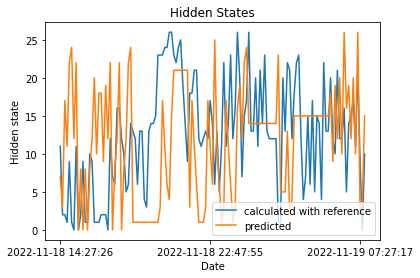

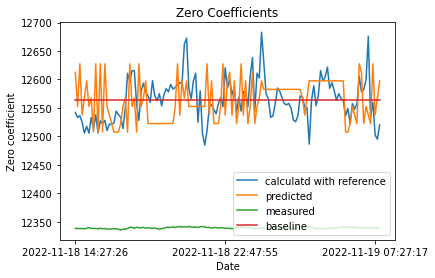

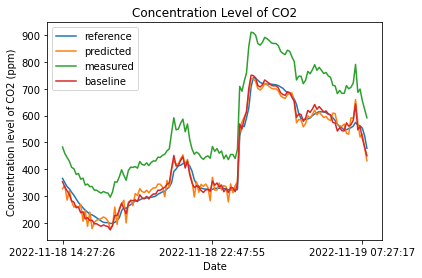

MSE(ref_zeros, mea_zeros): 227.925 
MSE(ref_zeros, pre_zeros): 48.099 
MSE(ref_zeros, base_zeros): 37.252

MSE(ref_CO2, mea_CO2): 137.818 
MSE(ref_CO2, pre_CO2): 27.411 
MSE(ref_CO2, base_CO2): 21.556



In [392]:
unsupervised_hmm()

print('MSE(ref_zeros, mea_zeros): {:.3f} \nMSE(ref_zeros, pre_zeros): {:.3f} \nMSE(ref_zeros, base_zeros): {:.3f}\n'.format(np.sqrt(np.linalg.norm(zeros - mea_zeros) ** 2 / N), np.sqrt(np.linalg.norm(zeros - pre_zeros) ** 2 / N), np.sqrt(np.linalg.norm(zeros - base_zeros) ** 2 / N)))
print('MSE(ref_CO2, mea_CO2): {:.3f} \nMSE(ref_CO2, pre_CO2): {:.3f} \nMSE(ref_CO2, base_CO2): {:.3f}\n'.format(np.sqrt(np.linalg.norm(ref_CO2 - data_CO2) ** 2 / N), np.sqrt(np.linalg.norm(ref_CO2 - pre_CO2) ** 2 / N), np.sqrt(np.linalg.norm(ref_CO2 - base_CO2) ** 2 / N)))